<div dir='rtl'><font face='B Mitra' size=6>
بارگذاری مدل آماده word2vec
</font></div>

<div dir='rtl'><font face="B Zar" size=4>

در ابتدا، مدل ترین شده word2vec توسط گوگل را در کولب بارگذاری میکنیم. برای این کار ابتدا مدل آموزش داده شده را در google drive آپلود کردیم و سپس آنرا در کولب بارگذاری کردیم.
سپس توسط gensim آنرا load میکنیم و برای پروژه از آن استفاده میکنیم.
</font></div>

In [ ]:
!gdown --id 11NlMteHJ5dAhuofIXY1ATZQAthIMVfp2

In [ ]:
import gensim
from gensim.models import KeyedVectors
from gensim import models

w2v_model = models.KeyedVectors.load_word2vec_format('/content/GoogleNews-vectors-negative300.bin.gz', binary=True)


<div dir='rtl'><font face="B Mitra" size=6>
دریافت دادگان
</font></div>


<div dir='rtl'><font face="B Zar" size=4>

فایل های csv مربوط به دادگان این تمرین را آپلود میکنیم. برای تسهیل این روند این فایلهارا در google drive آپلود کردیم و در ابتدای notebook آن ها را دانلود میکنیم.
</font></div>

In [ ]:
!gdown --id 1cV1ZTJURrpPfXetiypqGedVLJSanHLE3

In [ ]:
!unzip Data.zip

In [157]:
import pandas as pd
import numpy as np

data = pd.read_csv('dataset/train.csv')
test_data = pd.read_csv('dataset/test.csv')

In [126]:
data.head(5)

,Id,Comment,Topic
0,0x840,A few things. You might have negative- frequen...,Biology
1,0xbf0,Is it so hard to believe that there exist part...,Physics
2,0x1dfc,There are bees,Biology
3,0xc7e,I'm a medication technician. And that's alot o...,Biology
4,0xbba,Cesium is such a pretty metal.,Chemistry


In [127]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()


nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

<div dir='rtl'><font face="B Mitra" size=6>
پیش پردازش
</font></div>


<div dir='rtl'><font face="B Zar" size=4>

در این گام، روی داده ها پیش پردازش انجام میدهیم تا یادگیری بهتری داشته باشیم.
برای پردازش متن در پایتون، میتوانیم از کتابخانه nltk استفاده کنیم.
در گام اول، stopword ها شامل کلماتی که به درد پروسه یادگیری مان نمیخورند را از دیتافریم ها حذف میکنیم.

در این قسمت از lemmatizer نیز استفاده شده است که کلماتی را که در شکل اصلی خود نیستند را به شکل اصلی تبدیل میکند تا کار پردازش برای ما راحت تر شود برای مثال کلمه های جمع را به مفرد تبدیل میکند و ...
</font></div>

In [158]:
def process(x):
    tokens = word_tokenize(x)
    filtered = [lemmatizer.lemmatize(w) for w in tokens if not w.lower() in stopwords.words('english') and w.isalpha()]
    return ' '.join(filtered)

data['Comment'] = data['Comment'].apply(process)
test_data['Comment'] = test_data['Comment'].apply(process)

In [129]:
data

,Id,Comment,Topic
0,0x840,thing might frequency dependent selection goin...,Biology
1,0xbf0,hard believe exist particular ca detect anythi...,Physics
2,0x1dfc,bee,Biology
3,0xc7e,medication technician alot drug liver probably...,Biology
4,0xbba,Cesium pretty metal,Chemistry
...,...,...,...
8690,0x1e02,make similar observation last week southern Ge...,Biology
8691,0xc8d,would know,Biology
8692,0x723,Also use correct number sig fig,Chemistry
8693,0x667,ethical delimmas groundbreaking technology fut...,Biology


<div dir='rtl'><font face="B Zar" size=4>

در گام بعد، کل کلماتی که در train set استفاده شده است را استخراج کرده و بازنمایی word2vec آنها را پیدا میکنیم و در cluster_data ذخیره میکنیم تا به عنوان ورودی به الگوریتم کلاسترینگ داده شود.
</font></div>

In [159]:
unique_words = []
def count_unique(x):
    tokens = word_tokenize(x)
    for w in tokens:
        if w not in unique_words:
            unique_words.append(w)

data['Comment'].apply(count_unique)

0       None
1       None
2       None
3       None
4       None
        ... 
8690    None
8691    None
8692    None
8693    None
8694    None
Name: Comment, Length: 8695, dtype: object

In [160]:
cluster_data = []
words = []

for word in unique_words:
    try:
        cluster_data.append(w2v_model.get_vector(word))
        words.append(word)
    except:
        pass

In [161]:
np_data = np.asarray(cluster_data)

<div dir='rtl'><font face="B Mitra" size=6>
الگوریتم کلاسترینگ
</font></div>


<div dir='rtl'><font face="B Zar" size=4>
در گام اول الگوریتم خوشه بندی باید ماتریس فاصله original محاسبه شود که فاصله  دو داده را در خودش نگه میدارد و ما در اینجا از فاصله اقلیدسی استفاده کرده ایم.
</font></div>

In [ ]:
def calculate_D_original(data):
  
    n,m=data.shape
    d_org=np.zeros((n,n))
    for i in range (0,n): 
        for j in range(0,i):
            d_ij=int(np.linalg.norm(data[i]-data[j]))
            d_org[i, j] = d_ij
            d_org[j, i] = d_ij

    return d_org    


<div dir='rtl'><font face="B Zar" size=4>

در گام بعد، باید اندیس k نزدیک ترین همسایه هر داده را محاسبه کنیم.
به این صورت عمل میکنیم که سطر مربوط به داده در ماتریس فاصله را سورت کرده و k+1 عضو اول را به عنوان نزدیک ترین همسایه ها در نظر میگیریم. از آنجایی k+1 در نظر گرفتیم که اولین عدد، اندیس خود داده مورد نظر میباشد.
</font></div>

In [ ]:
# find k neighbours
def find_RK_intial(distance_matix,k):
 
    rk=[]
    n=distance_matix.shape[0]
    for i in range (0,n):
        sorted=np.argsort(distance_matix[i,:]) 
        rk.append(sorted[0:k+1])
    
    return np.asarray(rk)


<div dir='rtl'><font face="B Zar" size=4>
در گام بعد، مقدار دهی اولیه ماتریس d_current را انجام میدهیم.
به این صورت که فاصله دو داده در این ماتریس، برابر با میانگین دو به دو مجموعه داده ها به علاوه همسایه هایشان میباشد.
</font></div>

In [ ]:
def calculate_d_curr_intial(d_org, k, rk):
    n = d_org.shape[0]
    d_curr = np.zeros((n, n))
    for i in range(0, n):
        for j in range(0, i):
            sum=0
            for a in rk[i].tolist():
                for b in rk[j].tolist():
                    sum+=d_org[a,b]

            d_curr[i,j]=1/((k+1)**2) * sum
            d_curr[j, i]=1/((k+1)**2) * sum

    return d_curr   


<div dir='rtl'><font face="B Zar" size=4>
در گام بعد تابعی برای پیدا کردن عناصر کلیدی در هر مرحله در نظر میگیریم به این صورت که در ورودی مقدار c_curr را گرفته و به تعداد آن، عنصر کلیدی برمیگردانیم.
برای انتخاب عناصر کلیدی به این صورت عمل میکنیم که در ابتدا داده ای که به صورت میانگین، کمترین فاصله با هر یک از دیگر عناصر را دارد انتخاب کرده و به مجموعه sn اضافه میکنیم. سپس برای انتخاب عناصر دیگر، از مجموعه عناصری که تا به حال انتخاب نشده اند، عنصری که بیشترین کمینه فاصله با عناصری که تا به حال انتخال شده اند را انتخاب میکنیم.
</font></div>

In [ ]:
import math
def find_key(d_curr,c_curr):
    m = d_curr.shape[0]
    sum = []
    sn = []
    kn = [i for i in range(0, m)]
  
    for i in range(0, m):
        sum.append(d_curr[i].sum())
    sum = np.array(sum)  
    i_1 = sum.argmin()
  
    sn.append(i_1)
    kn.remove(i_1)

    n=1
    while n < c_curr:
        mins = []
        for i in kn:
            min = math.inf
            for j in sn:
                if d_curr[i, j] < min:
                    min = d_curr[i, j]

            mins.append(min)

        mins=np.asarray(mins)

        i_n=np.argmax(mins)
        sn.append(kn[i_n])
        kn.remove(kn[i_n])
        n+=1
    
    return sn   
 

<div dir='rtl'><font face="B Zar" size=4>
در این تابع، به هر داده، لیبل نزدیک ترین عنصر کلیدی که در تابع قبل محاسبه شد را اختصاص میدهیم.
و در آخر لیبل ها را scale میکنیم تا شماره لیبل ها به ترتیب باشد.
</font></div>

In [ ]:
import math
def update_labels(d_curr,sn,l):
    n=len(l)
    for i in range(0,n):
        if l[i] not in sn:
            min=math.inf
            min_idx=0
            for j in sn:
                if d_curr[l[i],j]<min: 
                    min=d_curr[l[i],j]
                    min_idx=j
            l[i]=min_idx  
    unique_labels=[]  
    for lab in l:
        if lab not in unique_labels: unique_labels.append(lab)
    for index,value in enumerate(unique_labels):
        for idx,lab in enumerate(l):
            if lab==value: l[idx]=index 

    return l    


<div dir='rtl'><font face="B Zar" size=4>
تابع find_P تابعی است که ایندکس یک داده را دریافت کرده و ایندکس خود داده و نزدیک ترین همسایه هایش را برمیگرداند.
</font></div>

In [ ]:
def find_P(l,rk,i,k):
  p=[]
  for index,lab in enumerate(l):
    if lab==i: 
      p.append(index)
      a= rk[index,1:k+1].tolist()
      for j in a: p.append(j)
  return p

<div dir='rtl'><font face="B Zar" size=4>
تابع update_d_curr، ماتریس d_curr را آپدیت میکند به این صورت که فاصله هر دو داده در این ماتریس برابر با میانگین فاصله دو به دو داده ها و نزدیکترین همسایه هایشان میشود.
</font></div>

In [ ]:
def update_d_curr(l, rk, d_original, k, c_curr):
    d_curr=np.zeros((c_curr, c_curr))
    for i in range(0, c_curr):
        p_i=find_P(l, rk, i, k)
        for j in range(0, i):
            p_j = find_P(l, rk, j, k)
            sum = 0
            for a in p_i:
                for b in p_j:
                    sum += d_original[a, b]
            d_curr[i,j] = sum/ (len(p_i) * len(p_j))
            d_curr[j,i] = sum/ (len(p_i) * len(p_j))

    return d_curr

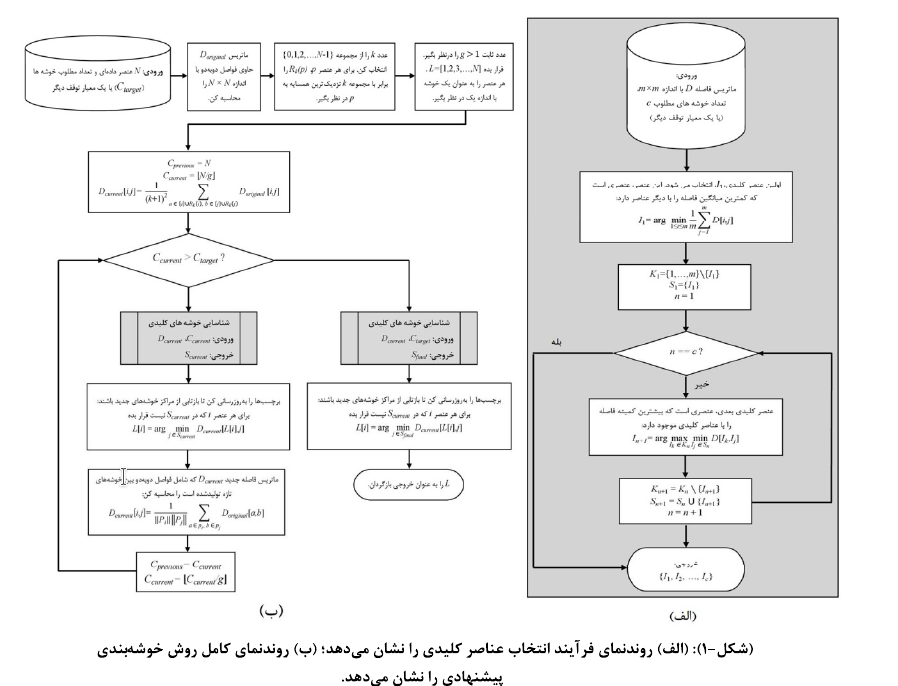

In [ ]:
def train_clustering_algorithm(data,k,g,c_target):
    d_original = calculate_D_original(data)  
    rk = find_RK_intial(d_original,k)
  
    n ,m = data.shape
    l = np.array([i for i in range(0, n)])
    c_prev = n
    c_curr = math.floor(n/g)
    d_curr=calculate_d_curr_intial(d_original,k,rk)

    while c_curr > c_target:
        sn = find_key(d_curr, c_curr)

    
        l = update_labels(d_curr, sn, l)

        uniqe_sn = []

        for val in l:
            if val not in uniqe_sn: uniqe_sn.append(val)


        d_curr = update_d_curr(l, rk, d_original, k, c_curr)
        c_prev = c_curr
        c_curr = math.floor(c_curr/g)

    sn = find_key(d_curr, c_curr)
    l = update_labels(d_curr, sn, l) 
    return l

In [ ]:
l = train_clustering_algorithm(np_data, 5, 5, 7500)

In [ ]:
l

array([  50,  271, 3442, ..., 2276, 5534, 1119])

<div dir='rtl'><font face="B Zar" size=4>

در گام بعد، کلماتی را که در الگوریتم کلاسترینگ در یک خوشه قرار گرفته اند را با نماینده کلاسترشان تعویض میکنیم در این صورت کلمات مشابه به یک صورت نمایش داده میشوند.
</font></div>

In [ ]:
def replace_words(x):
    tokens = word_tokenize(x)
    for index, value in enumerate(tokens):
        for i, val in enumerate(words):
            flag = False
            if (value == val):
                cluster_label = l[i]
                for j, label in enumerate(l):
                    if cluster_label == label:
                        tokens[index] = words[j]
                        flag = True
                        break
            if flag: break

    return ' '.join(tokens)


data2 = data.copy()
data2['Comment'] = data2['Comment'].apply(replace_words)

test_data2 = test_data.copy()
test_data2['Comment'] = test_data2['Comment'].apply(replace_words)

<div dir='rtl'><font face="B Zar" size=4>

سپس با استفاده از tfidfVectorizer که توسط scikit learn پیاده سازی شده است استفاده میکنیم و بازنمایی Comment های دیتاست را به دست می آوریم.
</font></div>

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing

tfidf_vectorizer = TfidfVectorizer(tokenizer=word_tokenize, max_features=7500)


X_train = tfidf_vectorizer.fit_transform(data2['Comment'].values)
X_test = tfidf_vectorizer.transform(test_data2['Comment'].values)

label_encoder = preprocessing.LabelEncoder()
y_train = label_encoder.fit_transform(data['Topic'].values)
y_test = label_encoder.transform(test_data['Topic'].values)

<div dir='rtl'><font face="B Zar" size=4>
در انتها، مدل SVM را روی داده های train به دست آمده آموزش میدهیم و با استفاده از داده های تست، Accuracy آنرا محاسبه میکنیم.
</font></div>

In [104]:
from sklearn.svm import SVC 
svm_model = SVC(kernel = 'rbf', C=1, gamma=0.7, decision_function_shape='ovr').fit(X_train, y_train) 
svm_predictions = svm_model.predict(X_test) 
accuracy = svm_model.score(X_test, y_test) 


In [105]:
accuracy

0.807061790668348

In [162]:
l2 = train_clustering_algorithm(np_data[0:400], 5, 1.2, 200)

In [163]:
for index, value in enumerate(l2):
    if (value == 55):
        print(words[index])

alot
definitely
pretty
really
always
awesome
kinda


In [164]:
for index, value in enumerate(l2):
    if (value == 13):
        print(words[index])

keeping
keep


In [165]:
for index, value in enumerate(l2):
    if (value == 4):
        print(words[index])

least
besides
part
single
